# Position Snapshots Analysis

Visualize intraday position performance to analyze optimal exit timing.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DB_PATH = '../data/earnings_trades.db'

# Load snapshots
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query("SELECT * FROM price_snapshots ORDER BY ts", conn)
conn.close()

print(f"Loaded {len(df)} snapshots")
df.head()

Loaded 119 snapshots


,id,trade_id,ts,minutes_since_open,straddle_mid,call_mid,put_mid,spot_price,unrealized_pnl,unrealized_pnl_pct,created_at
0,1,AEHR_2026-01-08_20260108200257,2026-01-09T09:30:00.007375-05:00,0,2.800,None,None,23.850,-725.0,-0.341176,2026-01-09 14:30:01
1,2,WDFC_2026-01-08_20260108200254,2026-01-09T09:30:00.007375-05:00,0,21.225,None,None,181.000,2257.5,0.270197,2026-01-09 14:30:03
2,3,AEHR_2026-01-08_20260108200257,2026-01-09T09:35:00.006291-05:00,5,2.800,None,None,22.220,-725.0,-0.341176,2026-01-09 14:35:01
3,4,WDFC_2026-01-08_20260108200254,2026-01-09T09:35:00.006291-05:00,5,23.200,None,None,177.210,3245.0,0.388390,2026-01-09 14:35:02
4,5,AEHR_2026-01-08_20260108200257,2026-01-09T09:40:00.007081-05:00,10,2.725,None,None,23.615,-762.5,-0.358824,2026-01-09 14:40:01


In [2]:
# Extract ticker from trade_id
df['ticker'] = df['trade_id'].str.split('_').str[0]
df['date'] = df['trade_id'].str.split('_').str[1]

# Convert to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Unique trades
print(f"Unique trades: {df['trade_id'].nunique()}")
print(df.groupby('ticker')['trade_id'].nunique())

Unique trades: 2
ticker
AEHR    1
WDFC    1
Name: trade_id, dtype: int64


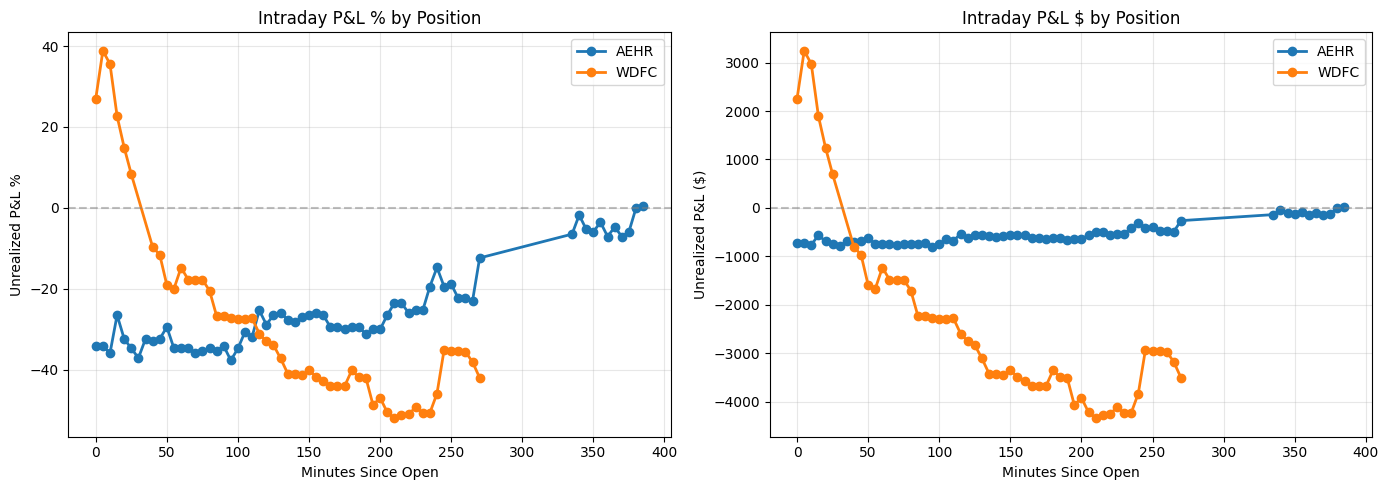

In [3]:
# Plot P&L % over time for each trade
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for trade_id in df['trade_id'].unique():
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    # Left plot: P&L %
    axes[0].plot(trade_df['minutes_since_open'], trade_df['unrealized_pnl_pct'] * 100, 
                 marker='o', label=ticker, linewidth=2, markersize=6)
    
    # Right plot: Absolute P&L
    axes[1].plot(trade_df['minutes_since_open'], trade_df['unrealized_pnl'], 
                 marker='o', label=ticker, linewidth=2, markersize=6)

axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Minutes Since Open')
axes[0].set_ylabel('Unrealized P&L %')
axes[0].set_title('Intraday P&L % by Position')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Minutes Since Open')
axes[1].set_ylabel('Unrealized P&L ($)')
axes[1].set_title('Intraday P&L $ by Position')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

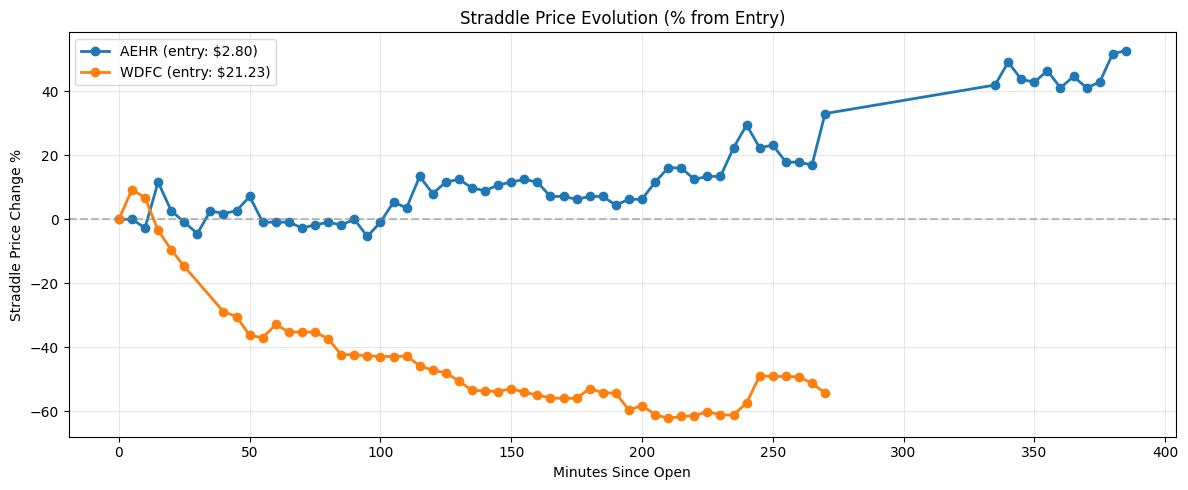

In [4]:
# Straddle mid price over time
fig, ax = plt.subplots(figsize=(12, 5))

for trade_id in df['trade_id'].unique():
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    # Normalize to % of initial value
    initial = trade_df['straddle_mid'].iloc[0]
    pct_change = (trade_df['straddle_mid'] / initial - 1) * 100
    
    ax.plot(trade_df['minutes_since_open'], pct_change, 
            marker='o', label=f"{ticker} (entry: ${initial:.2f})", linewidth=2, markersize=6)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Minutes Since Open')
ax.set_ylabel('Straddle Price Change %')
ax.set_title('Straddle Price Evolution (% from Entry)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Summary statistics by time bucket
summary = df.groupby('minutes_since_open').agg({
    'unrealized_pnl': ['mean', 'sum'],
    'unrealized_pnl_pct': ['mean', 'std'],
    'trade_id': 'count'
}).round(2)

summary.columns = ['Avg P&L $', 'Total P&L $', 'Avg P&L %', 'Std P&L %', 'N Positions']
summary['Avg P&L %'] = (summary['Avg P&L %'] * 100).round(1)
summary['Std P&L %'] = (summary['Std P&L %'] * 100).round(1)
print("P&L by Minutes Since Open:")
summary

P&L by Minutes Since Open:


,Avg P&L $,Total P&L $,Avg P&L %,Std P&L %,N Positions
minutes_since_open,,,,,
0,766.25,1532.5,-4.0,43.0,2
5,1260.00,2520.0,2.0,52.0,2
10,1103.75,2207.5,-0.0,51.0,2
15,666.25,1332.5,-2.0,35.0,2
20,278.75,557.5,-9.0,33.0,2
...,...,...,...,...,...
365,-100.00,-100.0,-5.0,NaN,1
370,-150.00,-150.0,-7.0,NaN,1
375,-125.00,-125.0,-6.0,NaN,1


In [6]:
# Best/worst times to exit
print("\n=== Exit Timing Analysis ===")
print("\nBest average P&L % by time:")
best_times = df.groupby('minutes_since_open')['unrealized_pnl_pct'].mean().sort_values(ascending=False)
print((best_times * 100).round(1).head(10))

print("\nTotal P&L $ by exit time:")
total_by_time = df.groupby('minutes_since_open')['unrealized_pnl'].sum().sort_values(ascending=False)
print(total_by_time.round(0).head(10))


=== Exit Timing Analysis ===

Best average P&L % by time:
minutes_since_open
5      2.4
385    0.6
380    0.0
10    -0.2
340   -1.8
15    -1.9
355   -3.5
0     -3.5
365   -4.7
345   -5.3
Name: unrealized_pnl_pct, dtype: float64

Total P&L $ by exit time:
minutes_since_open
5      2520.0
10     2207.0
0      1533.0
15     1332.0
20      557.0
385      13.0
380       0.0
340     -38.0
25      -43.0
355     -75.0
Name: unrealized_pnl, dtype: float64


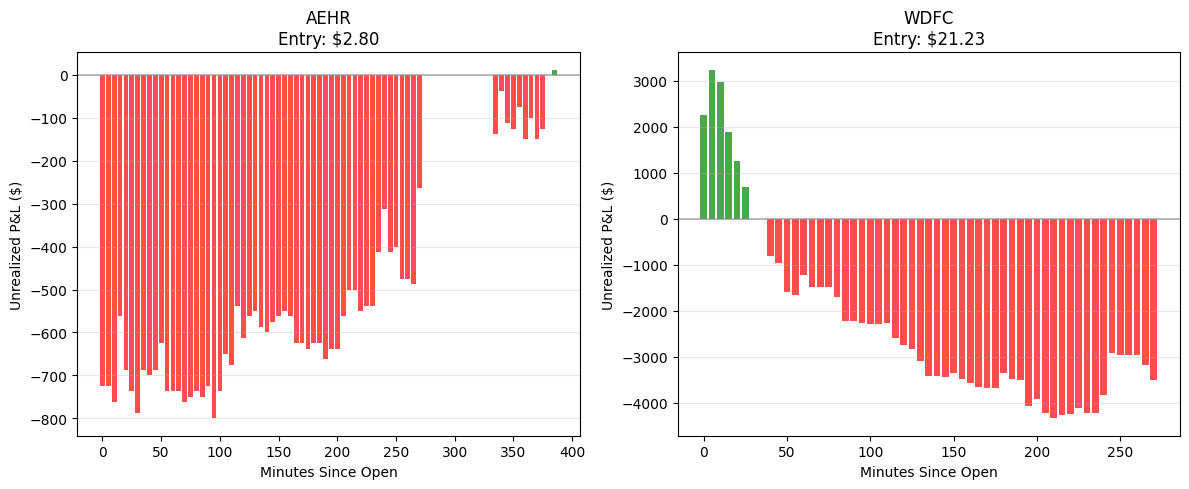

In [7]:
# Individual trade curves
n_trades = df['trade_id'].nunique()
fig, axes = plt.subplots(1, n_trades, figsize=(6*n_trades, 5))

if n_trades == 1:
    axes = [axes]

for i, trade_id in enumerate(df['trade_id'].unique()):
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    ax = axes[i]
    
    # Plot P&L with color based on value
    colors = ['green' if x >= 0 else 'red' for x in trade_df['unrealized_pnl']]
    ax.bar(trade_df['minutes_since_open'], trade_df['unrealized_pnl'], 
           color=colors, alpha=0.7, width=4)
    
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax.set_xlabel('Minutes Since Open')
    ax.set_ylabel('Unrealized P&L ($)')
    ax.set_title(f'{ticker}\nEntry: ${trade_df["straddle_mid"].iloc[0]:.2f}')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [8]:
# Load actual exit data for comparison
conn = sqlite3.connect(DB_PATH)
trades_df = pd.read_sql_query("""
    SELECT trade_id, ticker, premium_paid, exit_pnl, exit_pnl_pct, 
           realized_move_pct, implied_move, exit_datetime
    FROM trades 
    WHERE status = 'exited' AND exit_pnl IS NOT NULL
""", conn)
conn.close()

print(f"Completed trades: {len(trades_df)}")
trades_df

Completed trades: 12


,trade_id,ticker,premium_paid,exit_pnl,exit_pnl_pct,realized_move_pct,implied_move,exit_datetime
0,PENG_2026-01-06_20260106204607,PENG,2011.0275,-11.54,-0.005738,None,0.183380,2026-01-07T19:52:04
1,CALM_2026-01-07_20260106204608,CALM,2853.4875,-1206.59,-0.422847,None,0.071601,2026-01-07T19:51:41
2,STZ_2026-01-07_20260107200500,STZ,3900.0000,-1050.00,-0.269231,None,0.055634,2026-01-08T20:02:16.079767
3,JEF_2026-01-07_20260107200501,JEF,2350.0000,-350.00,-0.148936,None,0.071494,2026-01-08T20:02:16.079767
4,APLD_2026-01-07_20260107200503,APLD,2200.0000,-885.00,-0.402273,None,0.148161,2026-01-08T20:02:16.079767
5,AYI_2026-01-08_20260107200504,AYI,13975.0000,9925.00,0.710197,None,0.076120,2026-01-08T20:02:16.079767
6,HELE_2026-01-08_20260107200505,HELE,1950.0000,-875.00,-0.448718,None,0.184426,2026-01-08T20:02:16.079767
7,STZ_2026-01-07_20260107201729,STZ,3900.0000,-1050.00,-0.269231,None,0.055210,2026-01-08T20:02:16.079767
8,JEF_2026-01-07_20260107201730,JEF,2350.0000,-350.00,-0.148936,None,0.072475,2026-01-08T20:02:16.079767
9,APLD_2026-01-07_20260107201732,APLD,2165.0000,-850.00,-0.392610,None,0.144536,2026-01-08T20:02:16.079767


In [9]:
# Compare: What if we exited at different times?
print("\n=== What-If Exit Analysis ===")

for trade_id in df['trade_id'].unique():
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    # Find actual exit P&L if available
    actual = trades_df[trades_df['trade_id'] == trade_id]
    actual_pnl = actual['exit_pnl'].iloc[0] if len(actual) > 0 else None
    
    print(f"\n{ticker}:")
    print(f"  Best intraday P&L:  ${trade_df['unrealized_pnl'].max():,.0f} at {trade_df.loc[trade_df['unrealized_pnl'].idxmax(), 'minutes_since_open']} min")
    print(f"  Worst intraday P&L: ${trade_df['unrealized_pnl'].min():,.0f} at {trade_df.loc[trade_df['unrealized_pnl'].idxmin(), 'minutes_since_open']} min")
    print(f"  Latest snapshot:    ${trade_df['unrealized_pnl'].iloc[-1]:,.0f} at {trade_df['minutes_since_open'].iloc[-1]} min")
    if actual_pnl is not None:
        print(f"  Actual exit P&L:    ${actual_pnl:,.0f}")


=== What-If Exit Analysis ===

AEHR:
  Best intraday P&L:  $13 at 385 min
  Worst intraday P&L: $-800 at 95 min
  Latest snapshot:    $13 at 385 min
  Actual exit P&L:    $-262

WDFC:
  Best intraday P&L:  $3,245 at 5 min
  Worst intraday P&L: $-4,342 at 210 min
  Latest snapshot:    $-3,505 at 270 min
